In [16]:
import tribo as tb
import numpy as np
import os 
import re
import pandas as pd
from scipy.signal import savgol_filter as sgf

def split_string(s):
    return re.split('[-_]', s)

"""Self.outliers 

if not file.outlier:

"""
outlier_tests = {'OA_Project_Tests_CoF':['20wt_C20A2wtOA_10N_100mms_Test11', \
                       '20wt_C20A_20N_100mms_Test2', \
                        '20wt_C20A_20N_20mms_Test8', \
                        '20wt_C20A2wtOA_20N_20mms_Test7', \
						'100-TOCN_10N_20mms_Test7', \
						'100-TOCN_20N_20mms_Test10'], \
            
            'PAO_IL_ZDDP_CoF': ['0_OA0_20N_100mms_test2', \
                                '1_IL_20N_100mms_Test5', \
                                '1_IL_20N_20mms_Test2', \
                                '1_IL_20N_20mms_Test1'], \
			'OA_Project_Oils': ['20-PAO4+OA_10N_100mms_test3', \
					    		'20-PAO4+OA_10N_20mms_test2', \
								'20-PAO4+OA_20N_20mms_test2']}

class Tribo_file:
	def __init__(self,file_folder, file_name, outlier=False):
		self.file_name = file_name
		self.file_folder = file_folder
		self.percent,self.name,self.force,self.speed,self.test = split_string(self.file_name)
		self.outlier=outlier
		
		self.load_data()

	def load_data(self):
		self.data,self.xpos,self.Fx,self.Fz = tb.get_data(self.file_folder+"\\"+self.file_name,"all")
		

	def process_data(self,cutoff=0.1):

		self.xpos_peaks, self.xpos_valleys = tb.find_x_segments(self.xpos)

		segments=tb.segment_data(self.xpos, self.xpos_peaks, self.xpos_valleys,self.Fx,self.Fz)

		self.upward_sections, self.forward_friction, self.downward_sections, self.backward_friction=segments

		self.CoF_array = tb.calculate_CoF(self.upward_sections, self.forward_friction, self.downward_sections, self.backward_friction,cutoff)

		self.CoF_avg=np.average(self.CoF_array)
		self.CoF_std=np.std(self.CoF_array, ddof=1)

		pad_length = 3000 - len(self.CoF_array)
		if pad_length > 0:
			padded_array = np.pad(file_n.CoF_array, (0, pad_length), 'constant', constant_values=self.CoF_avg)
		else:
			padded_array = file_n.CoF_array

		self.CoF_array=padded_array




		

folder = 'OA_Project_Oils'

files_in_folder = os.listdir(folder)
#--------------------MARK: Extra Addition--------------------- 
# files_in_folder = []
# for root, dir, files in os.walk(folder):
# 	if not files:
# 		continue

# 	files_in_folder += files

#-----------------------------------------

print(f" Found {len(files_in_folder)} files in {folder}")

Tribo_files = []
complete_CoF_df = pd.DataFrame()
sg_smoothing = pd.DataFrame()

test_list = [] # testing 

for file_name in files_in_folder:
	if folder in outlier_tests.keys():
		if file_name in outlier_tests[folder]:
			test_list.append(file_name)
			file_n=Tribo_file(folder, file_name, outlier=True)
		else:
			file_n=Tribo_file(folder, file_name, outlier=False)
	file_n.process_data(0.2)
	Tribo_files.append(file_n)
	# print(f"Processed {file_name} with CoF {file_n.CoF_array.shape} and % {file_n.percent} ")
	complete_CoF_df[file_name]=file_n.CoF_array

for column in complete_CoF_df.columns:
	sg_smoothing[column]=sgf(complete_CoF_df[column], 100, 2)

speeds=[]
names=[]
# outliers = []

for file in Tribo_files:
	if file.speed not in speeds:
		speeds.append(file.speed)

	if file.name not in names:
		names.append(file.name)
	# if file.outlier:
	# 	outliers.append(file.file_name)

# print(f" Procesing {speeds}")

speed_sheets=[]

# for speed in speeds:
# 	files_with_speed = [file for file in Tribo_files if file.speed == speed]

	
# 	rows=[]
# 	ii=0
# 	for file in files_with_speed:
# 		data_to_append = [ file.name,  file.CoF_avg,  file.CoF_std,file.percent,file.force,file.test]
# 		rows.append(data_to_append)

# 	df = pd.DataFrame(rows,columns=['Name','CoF_avg','CoF_std','Percent','Force','Test'])


# 	speed_sheets.append(df)

rows=[]
count1 = 0 # Testing
for file in Tribo_files:
	if file.outlier:
		count1 += 1
		print(f"Outlier found: {file.file_name}")
		continue
	if file.speed == '10mms':
		continue
	data_to_append = [ file.name,  file.CoF_avg,  file.CoF_std,file.speed, file.percent, file.force,file.test]
	rows.append(data_to_append)

print('Outliers num: ', count1)
print('Outlier Files found: ', test_list)
	

df = pd.DataFrame(rows,columns=['Name','CoF_avg','CoF_std','Speed','Percent','Force','Test'])

print("This is the complete df\n",df)
for speed in speeds:
	speed_sheet=df[df['Speed']==speed]
	print("speed sheet\n",speed_sheet)
	speed_sheets.append(speed_sheet)

rows_total=[]
total_dfs=[]
with pd.ExcelWriter(f'{folder}.xlsx') as writer: 
	for df,speed  in zip(speed_sheets,speeds): 
		rows_total=[]

		for name in df['Name'].unique():
			for force in df['Force'].unique():
				print(f"----------{name}\t{force}------------")
				df2=df[(df['Name']==name) & (df['Force']==force)]
				if df2.empty:
					continue
				CoF_total_avg=np.average(df2['CoF_avg'])
				CoF_total_std=np.sqrt(np.sum(df2['CoF_std'].to_numpy()**2))/len(df2['CoF_std'])
				print(f"std: {np.average(df2['CoF_std'])}\t {CoF_total_std}")
				print(df2.get("Force").iloc[0],df2.get("Percent").iloc[0])

				row=[name,CoF_total_avg,CoF_total_std,speed,df2.get("Force").iloc[0],df2.get("Percent").iloc[0]]
				
			
				print(row)
				rows_total.append(row)
		df=pd.DataFrame(rows_total,columns=['Name','CoF_avg','CoF_std','Speed', 'Force','Percent'])
		total_dfs.append(df)
		df.to_excel(writer, sheet_name=speed, index=False)
	
	complete_df=pd.concat(total_dfs)
	complete_df.to_excel(writer, sheet_name='Total', index=False)
	complete_CoF_df.to_excel(writer, sheet_name='CoF', index=True)
	sg_smoothing.to_excel(writer, sheet_name='Smoothed CoF', index=True)
	
		



 Found 12 files in OA_Project_Oils
Outlier found: 20-PAO4+OA_10N_100mms_test3
Outlier found: 20-PAO4+OA_10N_20mms_test2
Outlier found: 20-PAO4+OA_20N_20mms_test2
Outliers num:  3
Outlier Files found:  ['20-PAO4+OA_10N_100mms_test3', '20-PAO4+OA_10N_20mms_test2', '20-PAO4+OA_20N_20mms_test2']
This is the complete df
       Name   CoF_avg   CoF_std   Speed Percent Force       Test
0  PAO4+OA  0.105522  0.017073  100mms      20   10N      test4
1  PAO4+OA  0.105755  0.017212  100mms      20   10N  test4copy
2  PAO4+OA  0.132318  0.014922   20mms      20   10N      test5
3  PAO4+OA  0.144713  0.015876   20mms      20   10N      test6
4  PAO4+OA  0.101534  0.009639  100mms      20   20N      test3
5  PAO4+OA  0.106155  0.009471  100mms      20   20N      test7
6  PAO4+OA  0.105845  0.008228  100mms      20   20N      test8
7  PAO4+OA  0.112030  0.014120   20mms      20   20N      test1
8  PAO4+OA  0.104206  0.010796   20mms      20   20N  test1copy
speed sheet
       Name   CoF_avg   CoF_st

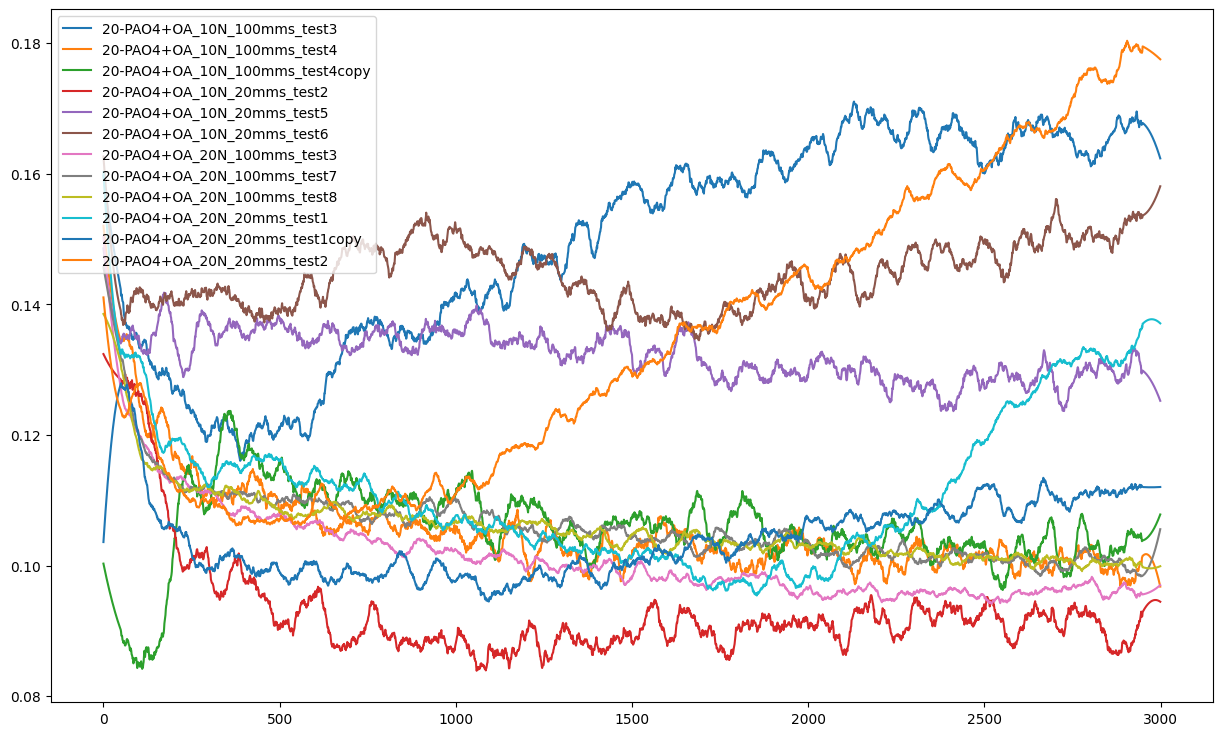

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))
for column in sg_smoothing.columns:
    if '20N' or '10N' in column:
        plt.plot(sg_smoothing[column],label=column)
        plt.legend()
plt.show()



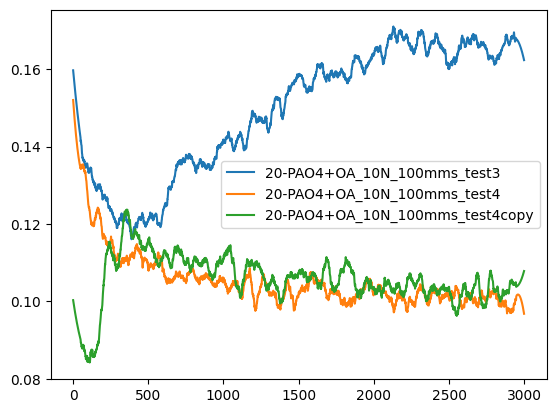

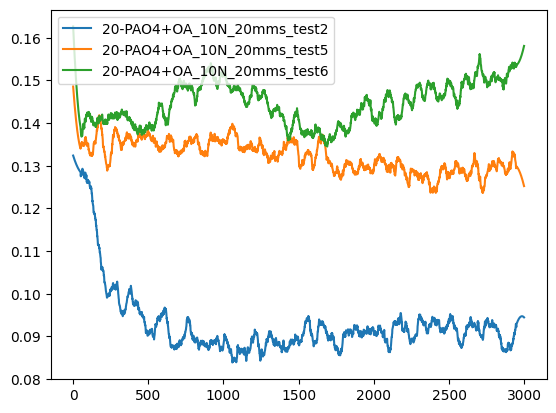

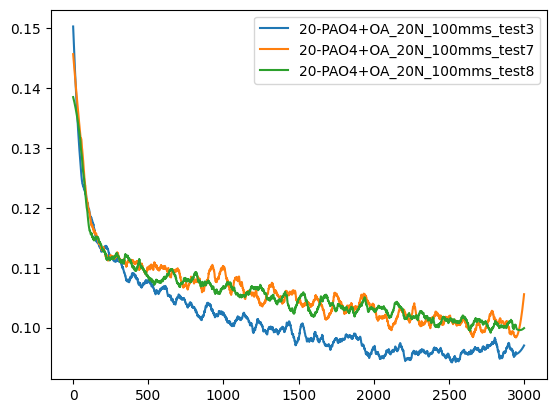

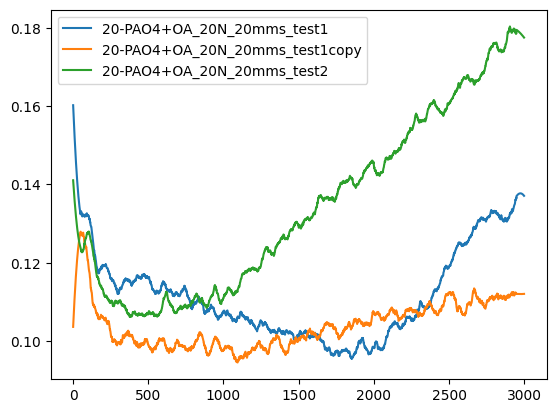

In [18]:

avg_CoF_tests = {'OA_Project_Tests_CoF':['20wt_C20A_10N_20mms_Test6', \
                                         '20wt_C20A_10N_100mms_Test14', \
                                         '20wt_C20A_20N_20mms_Test16new', \
                                         '20wt_C20A_20N_100mms_Test12', \
                                        '20wt_C20A2wtOA_10N_20mms_Test8', \
                                        '20wt_C20A2wtOA_10N_100mms_Test4', \
                                        '20wt_C20A2wtOA_20N_20mms_Test6', \
                                        '20wt_C20A2wtOA_20N_100mms_Test17new', \
                                        '100-TOCN_10N_100mms_Test12', \
                                        '100-TOCN_10N_20mms_Test6', \
                                        '100-TOCN_20N_100mms_Test14'], \
                                        
                 'PAO_IL_ZDDP_CoF': ['0_OA0_20N_100mms_test13', \
                                     '0_OA0_20N_20mms_test1', \
                                     '1-ZADP_20N_100mms_Test5', \
                                     '1-ZADP_20N_20mms_Test3', \
                                     '1_IL_20N_100mms_Test5', \
                                     '1_IL_20N_20mms_Test4']}                      

pattern = r'(_test|_Test).*'
pattern2 = r'_[^_]*$'
unique_names = {}

for column in sg_smoothing.columns:
    if '10mms' in column:
         continue
    if '20N' or '10N' in column:
    # if '20N' in column:

        # Apply the regex pattern to get the unique name
        unique_name = re.sub(pattern2, '', column)
        # Check if the unique name is already a key in the dictionary
        if unique_name in unique_names:
            # Append the original column name to the list associated with the unique name
            unique_names[unique_name].append(column)
        else:
                # Create a new entry with the unique name as the key and a list containing the original column name
                unique_names[unique_name] = [column]

os.makedirs(f'{folder}_Images', exist_ok=True)

for (key, value) in unique_names.items():
    for spec_val in value:
        plt.plot(sg_smoothing[spec_val],label=spec_val)
    # plt.title(key)
    plt.legend()
    plt.savefig(os.path.join(f'{folder}_Images', f'{key}.png'))
    plt.show()    
    # print(key, unique_names[key])

# for column in sg_smoothing.columns:
#     if '20N' in column:
#         if re.sub(pattern, '', column) in unique_names:
            
#             plt.plot(sg_smoothing[column],label=column)
#             plt.legend()

In [ ]:
# with pd.ExcelWriter(f'{folder}.xlsx') as writer:
    # print(sg_smoothing.head())
print(avg_CoF_tests[folder], f'\n Length: {len(avg_CoF_tests[folder])}')
count =0
good_test_in_folder_list = []
for ii in range(len(sg_smoothing.columns)):
    for jj in range(len(avg_CoF_tests[folder])):
        # print(  avg_CoF_tests[folder][jj]==sg_smoothing.columns[ii])
        if  avg_CoF_tests[folder][jj]==sg_smoothing.columns[ii]:
            count+=1
            print(avg_CoF_tests[folder][jj])
            good_test_in_folder_list.append(avg_CoF_tests[folder][jj])
print(count)

good_test_df = sg_smoothing.loc[:, good_test_in_folder_list]

# for good_test in avg_CoF_tests[folder]:
#     good_test_df = pd.concat([good_test_df, sg_smoothing[good_test]], ignore_index=True)
print(good_test_df)

with pd.ExcelWriter(f'{folder}.xlsx', engine='openpyxl', mode='a') as writer: 
    good_test_df.to_excel(writer, sheet_name='Good_Tests', index=False)
    # good_test_df.to_excel(writer, sheet_name='Good Tests', index=False)
